## Some misc. code snippets while learning diffusion

In [1]:
%load_ext autoreload

In [2]:
%autoreload
# import libraries
import numpy as np
import pickle as pkl
import os
import sys
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
%matplotlib inline

from celeba_dataset import CelebA
from unet_diffusion import UNet_Diffusion, get_time_embedding
from noise_scheduler import LinearNoiseScheduler

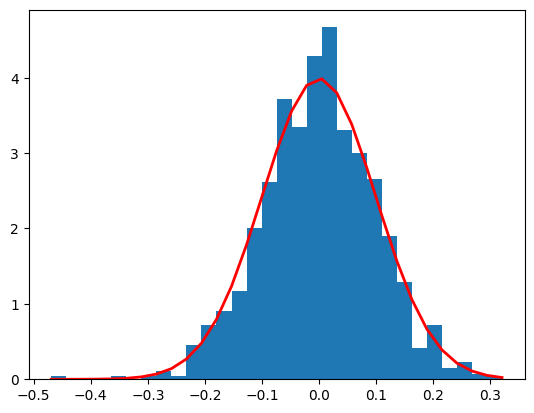

In [3]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)


# Verify the mean and the variance: 
abs(mu - np.mean(s))
0.0  # may vary

abs(sigma - np.std(s, ddof=1))
0.1  # may vary


# Display the histogram of the samples, along with the probability density function:
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [4]:
%autoreload
import os
import torch
from torch import utils
from torch import nn
import pytorch_lightning as pl
from torchvision import transforms
from torchvision.transforms.v2 import Resize, Compose, ToDtype, RandomHorizontalFlip, RandomVerticalFlip 
from torchvision.transforms.v2 import RandomResizedCrop, RandomRotation, GaussianBlur, RandomErasing


#--------------------------------------------------------------------
# Dataset, Dataloader
#--------------------------------------------------------------------
from pathlib import Path
image_dir_train = Path('../data/img_align_celeba/img_align_celeba/')

img_size = (64,64) 
batch_size = 8 


train_transforms = Compose([ToDtype(torch.float32, scale=False),
                            RandomHorizontalFlip(p=0.50),
                            # RandomVerticalFlip(p=0.25),
                            # transforms.RandomApply(nn.ModuleList([GaussianBlur(kernel_size=7)]), p=0.5),
                            # transforms.RandomApply(nn.ModuleList([RandomRotation(10.0)]), p=0.5),
                            # RandomResizedCrop(size=img_size, scale=(0.3, 1.0), antialias=True),
                            # RandomErasing(p=0.5, scale=(0.02, 0.20)),
                            Resize(img_size, antialias=True)
                            ])

train_dataset = CelebA(image_dir_train, transform=train_transforms)
train_loader = utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=5, persistent_workers=True)


Dataset has 202599 rows


In [5]:
class UnNormalize(object):
    def __init__(self) : #, mean, std):
        pass
    def __call__(self, img):
        img = (img*127.5) + 127.5
        return img
    
unorm  = UnNormalize()

torch.Size([8, 3, 64, 64])
tensor(-1.) ,  tensor(0.9984)
num rows: 4 , num cols: 4


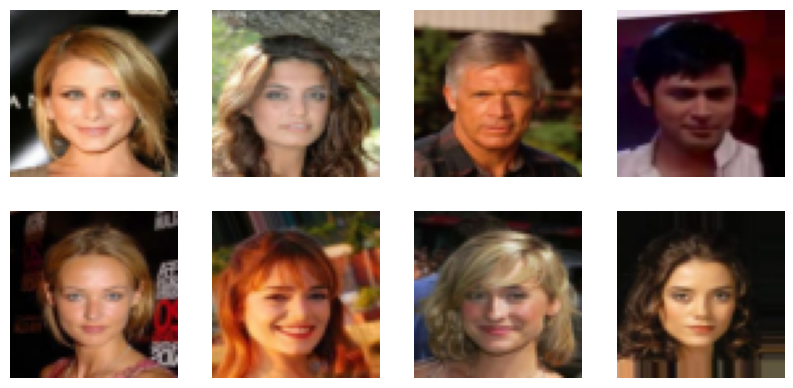

In [6]:
import matplotlib.pyplot as plt

images, _  = next(iter(train_loader))
print(images.shape)
print(torch.min(images[0]), ', ', torch.max(images[0]))


cols = 4
rows = 4
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(10, 10))
idx = 0
for img in (images):  
    img = unorm(img).to(torch.uint8).permute(1, 2, 0)
    # target = unorm(target).to(torch.uint8).permute(1, 2, 0)

    idx += 1
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    plt.imshow(img)

    if idx == (cols*rows):
        break



In [7]:
num_timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
lns = LinearNoiseScheduler(num_timesteps, beta_start, beta_end)

In [8]:
images_0, _  = next(iter(train_loader))
shape = images_0.shape
print(shape)
noise = torch.randn(shape[2], shape[3])
print(noise.shape)
print(images[0:5].shape)

imgs_n = lns.add_noise(images[0:1], noise, 50)
print(imgs_n.shape)

torch.Size([8, 3, 64, 64])
torch.Size([64, 64])
torch.Size([5, 3, 64, 64])
torch.Size([1, 3, 64, 64])


num rows: 1 , num cols: 2


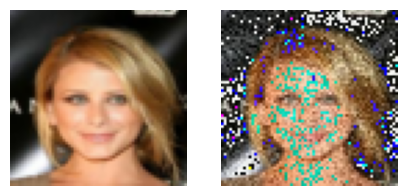

In [9]:
import matplotlib.pyplot as plt

cols = 2
rows = 1
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(5, 5))
idx = 0

img   = unorm(images[0]).to(torch.uint8).permute(1, 2, 0)
img_n = unorm(imgs_n[0]).to(torch.uint8).permute(1, 2, 0)

idx += 1
ax = plt.subplot(rows, cols, idx)
ax.axis('off')
plt.imshow(img)

idx += 1
ax = plt.subplot(rows, cols, idx)
ax.axis('off')
plt.imshow(img_n)



In [10]:
time_emb_dim = 128
time_steps = torch.ones((512)) * 999
print(time_steps.shape)

blah = time_steps[:, None]
print(blah.shape)

poo = blah.repeat(1, 128//2)
print(poo.shape)


t_emb = get_time_embedding(time_steps, time_emb_dim)
print(t_emb.shape)
print(t_emb)

torch.Size([512])
torch.Size([512, 1])
torch.Size([512, 64])
torch.Size([512, 128])
tensor([[-0.0265, -0.9170,  0.9921,  ...,  0.9882,  0.9911,  0.9934],
        [-0.0265, -0.9170,  0.9921,  ...,  0.9882,  0.9911,  0.9934],
        [-0.0265, -0.9170,  0.9921,  ...,  0.9882,  0.9911,  0.9934],
        ...,
        [-0.0265, -0.9170,  0.9921,  ...,  0.9882,  0.9911,  0.9934],
        [-0.0265, -0.9170,  0.9921,  ...,  0.9882,  0.9911,  0.9934],
        [-0.0265, -0.9170,  0.9921,  ...,  0.9882,  0.9911,  0.9934]])


-------------------------------------------
## Training

In [11]:
# Instantiate the model
time_emb_dim = 256 #128
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [ ]:
%autoreload
from unet_diffusion import UNet_Diffusion
from tqdm import tqdm
from torch.optim import Adam

# Instantiate the model
time_emb_dim = 256 #128

def train(model):
    model.train()

    # Create the noise scheduler
    num_timesteps = 1000
    beta_start = 0.0001
    beta_end = 0.02
    scheduler = LinearNoiseScheduler(num_timesteps=num_timesteps,
                                     beta_start=beta_start,
                                     beta_end=beta_end)
    
    # Create the dataset
    train_dataset = CelebA(image_dir_train, transform=train_transforms)
    train_loader = utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=5, persistent_workers=True)    
    
    
    # Create output directories
    default_output_dir = 'default'
    if not os.path.exists(default_output_dir):
        os.mkdir(default_output_dir)
    
    # Specify training parameters
    num_epochs = 500
    optimizer = Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.MSELoss()
    
    # Run training
    for epoch_idx in range(num_epochs):
        losses = []
        for im in tqdm(train_loader):
            optimizer.zero_grad()

            im = im[0]
            im = im.float().to(device)
            
            # Sample random noise
            noise = torch.randn_like(im) #.to(device)
            
            # Sample timestep
            t = torch.randint(0, num_timesteps, (im.shape[0],)) #.to(device)
            
            # Add noise to images according to timestep
            noisy_im = scheduler.add_noise(im, noise, t).to(device)

            # Model tries to learn the noise that was added to im to make noise_im
            noise_pred = model(noisy_im, t.to(device))

            # Loss is our predicted noise relative to actual noise
            loss = criterion(noise_pred.to(device), noise.to(device))

            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        print('Finished epoch:{} | Loss : {:.4f}'.format(
            epoch_idx + 1,
            np.mean(losses),
        ))
        torch.save(model.state_dict(), os.path.join('default', 'model_ckpt.pth'))
    
    print('Done Training ...')
    

In [12]:
model = UNet_Diffusion(time_emb_dim).to(device)
total_params = sum(
	param.numel() for param in model.parameters()
)
print('Model has:', int(total_params//1e6), 'M parameters')


Model has: 42 M parameters


In [ ]:

train(model)

---------------------------------------------------------
## Inference

In [ ]:
import torchvision
import argparse
import yaml
import os
from torchvision.utils import make_grid
from unet_diffusion import UNet_Diffusion
from diffusion_lightning import DDPM
from tqdm import tqdm

num_samples = 25
num_grid_rows = 5
im_channels = 3
im_size = img_size[0]
num_timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
task_name = 'default'
ckpt_name = 'model_ckpt.pth'

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

def sample(model, scheduler):
    r"""
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    xt = torch.randn((num_samples, im_channels, im_size, im_size)).to(device)

    for i in tqdm(reversed(range(num_timesteps))):
        # Get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        # Save x0 every 200th time.
        if i % 200 == 0 or (i == num_timesteps-1):
            ims = torch.clamp(xt, -1., 1.).detach().cpu()
            ims = (ims + 1) / 2
            grid = make_grid(ims, nrow=num_grid_rows)
            img = torchvision.transforms.ToPILImage()(grid)
            if not os.path.exists(os.path.join(task_name, 'samples')):
                os.mkdir(os.path.join(task_name, 'samples'))
            img.save(os.path.join(task_name, 'samples', 'x0_{}.png'.format(i)))
            img.close()


def infer():
    model = DDPM.load_from_checkpoint(checkpoint_path='/home/mark/dev/diffusion/lightning_logs/version_6/checkpoints/epoch=4-step=84420.ckpt') 
    # model = UNet_Diffusion(time_emb_dim).to(device)
    # model.load_state_dict(torch.load(os.path.join(task_name, ckpt_name), map_location=device))
    model.eval()
    model.to(device)
    
    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=num_timesteps,
                                     beta_start=beta_start,
                                     beta_end=beta_end)
    with torch.no_grad():
        sample(model.model, scheduler)

    return



#----------------------------------------------------
# Run the inference
#----------------------------------------------------
infer()


In [ ]:
0 % 100